In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import re

In [8]:
##################################################
####### import function 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


### Full cycle

File Syloid/27C/syloid_kinetics_50-100um_20mg_27C-2021-07-08 14-48-29.xls read succesfull


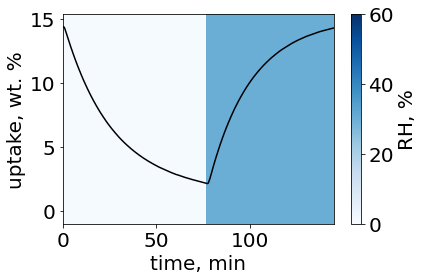

In [9]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/'

filelist = ['Syloid/27C/syloid_kinetics_50-100um_20mg_27C-2021-07-08 14-48-29.xls']

# color list
name_and_color_dictionary = {'Syloid/27C/syloid_kinetics_50-100um_20mg_27C-2021-07-08 14-48-29.xls':{'color':'black', 'name':'Syloid'},
                            }
text_size = 20
Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

import numpy as np
import matplotlib as mpl

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=60)

fig, ax1 = plt.subplots()
for m, Sorption in enumerate([i for i in Water_Sorption_list if i.filename == 'Syloid/27C/syloid_kinetics_50-100um_20mg_27C-2021-07-08 14-48-29.xls']):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
    ax1.plot(Sorption.data.iloc[split_index_ads[0]:split_index_ads[2], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_ads[2], :]['time'].min()-75,
             Sorption.data.iloc[split_index_ads[0]:split_index_ads[2], :]['uptake'], 
             c=name_and_color_dictionary[Sorption.filename]['color'],
             label='uptake')
    arr = np.tile(np.array(Sorption.data.iloc[split_index_ads[0]:split_index_ads[2], :]['RH_target']), (2, 1))
    ax2 = plt.contourf(Sorption.data.iloc[split_index_ads[0]:split_index_ads[2], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_ads[2], :]['time'].min()-75,
                       [Sorption.data.iloc[split_index_ads[0]:split_index_ads[2], :]['uptake'].min()-1, Sorption.data.iloc[split_index_ads[0]:split_index_ads[2], :]['uptake'].max()+1], 
                       arr, 
                       cmap=cmap,
                       #norm = norm, 
                       levels=np.arange(60))

ax1.tick_params(axis='x', labelsize=text_size)
ax1.tick_params(axis='y', labelsize=text_size)
ax1.set_xlabel('time, min', fontsize=text_size)
ax1.set_ylabel('uptake, wt. %', fontsize=text_size)
ax1.set_xlim([0, 145])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
               )
cbar.ax.tick_params(labelsize=text_size)
cbar.set_label('RH, %', rotation=90, fontsize=text_size)

plt.tight_layout()
plt.savefig('Figure3_fullcycle.png', dpi=600)
plt.show()

### Partial cycling

In [10]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/Syloid/27C/hm/'

filelist = os.listdir(path)
filelist = [i for i in filelist if i[-4:]=='.xls']
# color list
name_and_color_dictionary = {'CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls':{'color':'b', 'name':'CAU-10-H'},
                             'MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls':{'color':'r', 'name':'MOF-160'},
                            'MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls':{'color':'g', 'name':'MOF-303'},
                            'ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls':{'color':'m', 'name':'ROS-037'},
                            'ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls':{'color':'c', 'name':'ROS-039'},
                            'ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls':{'color':'darkorange', 'name':'ROS-040'},
                            'Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls':{'color':'grey', 'name':'Syloid'},
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

File Heatmap_validation-syloid_heatmap_50-100um_20mg_27C-2021-07-09 12-30-08.xls read succesfull
File Heatmap_validation-syloid_heatmap_50-100um_20mg_27C-2021-07-09 15-28-18.xls read succesfull
File Heatmap_validation-syloid_heatmap_50-100um_20mg_27C-2021-07-09 19-56-09.xls read succesfull
File Heatmap_validation-syloid_heatmap_50-100um_20mg_27C-2021-07-10 00-29-16.xls read succesfull
File Heatmap_validation-syloid_heatmap_50-100um_20mg_27C-2021-07-10 04-49-36.xls read succesfull
File Heatmap_validation-syloid_heatmap_50-100um_20mg_27C-2021-07-10 10-45-45.xls read succesfull


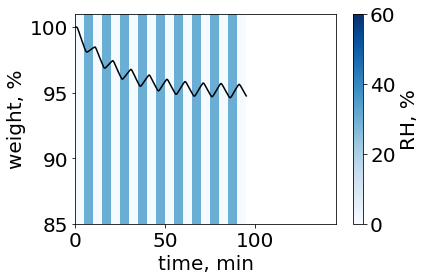

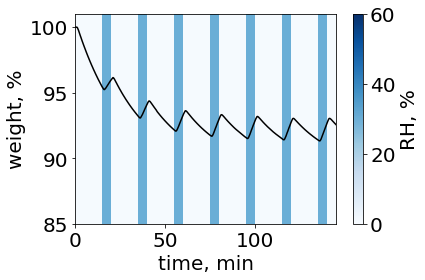

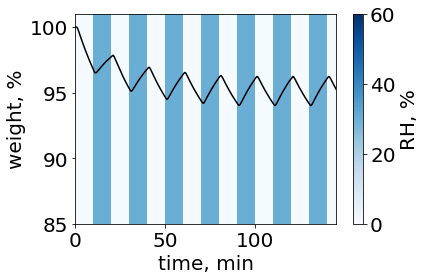

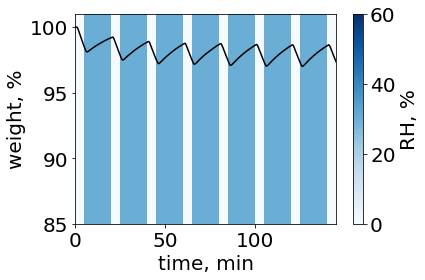

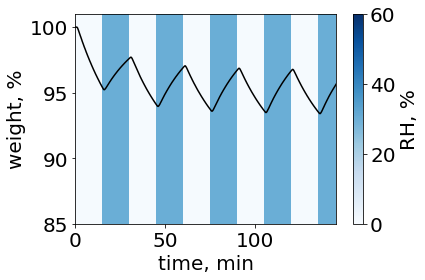

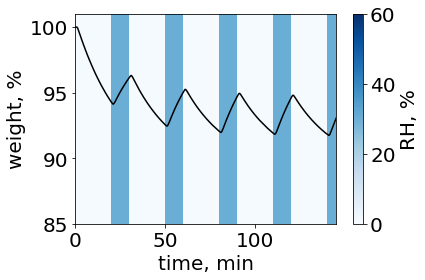

In [11]:
import numpy as np
import matplotlib as mpl

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=60)

text_size = 20
for m, Sorption in enumerate(Water_Sorption_list ):
    fig, ax1 = plt.subplots()
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
    ax1.plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[-1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[-1], :]['time'].min(),
             (Sorption.data.iloc[split_index_des[0]:split_index_ads[-1], :]['mass']/Sorption.data.iloc[split_index_des[0]:split_index_ads[-1], :]['mass'].max())*100 , 
             c='black',
             label='uptake')
    arr = np.tile(np.array(Sorption.data.iloc[split_index_des[0]:split_index_ads[-1], :]['RH_target']), (2, 1))
    ax2 = plt.contourf(Sorption.data.iloc[split_index_des[0]:split_index_ads[-1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[-1], :]['time'].min(),
                       [85,101], 
                       arr, 
                       cmap=cmap,
                       #norm = norm, 
                       levels=np.arange(60))
    
    ax1.set_xlabel('time, min', fontsize=text_size)
    ax1.set_ylabel('weight, %', fontsize=text_size)
    #ax2.set_ylabel('RH target, %', c='b')
    ax1.tick_params(axis='x', labelsize=text_size)
    ax1.tick_params(axis='y', labelsize=text_size)
    
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                   )
    cbar.ax.tick_params(labelsize=text_size)
    cbar.set_label('RH, %', rotation=90, fontsize=text_size)
    plt.tight_layout()
    ax1.set_xlim([0, 145])
    plt.savefig('Figure3_{0}.png'.format(str(m)), dpi=600)
    plt.show()

## Heatmap syloid

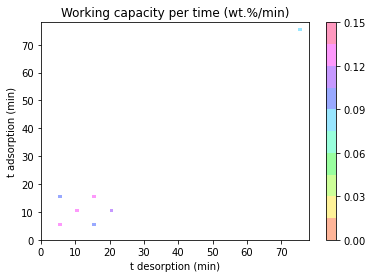

In [16]:
max_wc = 0.15
max_diff = 1
idx = 30
text_size = 16
number_of_steps = 79
working_capacity_per_time_array = np.ones([number_of_steps, number_of_steps])*10000
working_capacity_per_time_array[5, 5] = 0.1216
working_capacity_per_time_array[6, 6] = 0.1216
working_capacity_per_time_array[5, 6] = 0.1216
working_capacity_per_time_array[6, 5] = 0.1216
working_capacity_per_time_array[10, 10] = 0.1243
working_capacity_per_time_array[11, 11] = 0.1243
working_capacity_per_time_array[11, 10] = 0.1243
working_capacity_per_time_array[10, 11] = 0.1243
working_capacity_per_time_array[15, 5] = 0.0975
working_capacity_per_time_array[16, 6] = 0.0975
working_capacity_per_time_array[16, 5] = 0.0975
working_capacity_per_time_array[15, 6] = 0.0975
working_capacity_per_time_array[5, 15] = 0.0979
working_capacity_per_time_array[6, 16] = 0.0979
working_capacity_per_time_array[6, 15] = 0.0979
working_capacity_per_time_array[5, 16] = 0.0979
working_capacity_per_time_array[15, 15] = 0.1261
working_capacity_per_time_array[16, 16] = 0.1261
working_capacity_per_time_array[15, 16] = 0.1261
working_capacity_per_time_array[16, 15] = 0.1261
working_capacity_per_time_array[10, 20] = 0.1157
working_capacity_per_time_array[11, 21] = 0.1157
working_capacity_per_time_array[11, 20] = 0.1157
working_capacity_per_time_array[10, 21] = 0.1157
working_capacity_per_time_array[75, 75] = 0.08
working_capacity_per_time_array[76, 76] = 0.08
working_capacity_per_time_array[75, 76] = 0.08
working_capacity_per_time_array[76, 75] = 0.08

fig,ax = plt.subplots(1,1)
cp = ax.contourf(working_capacity_per_time_array, 
                levels=[h*max_wc for h in np.linspace(0, 1, 11)], vmin=0, vmax=max_wc, cmap='hsv', alpha=0.4)
#cp = ax.contourf(t_des_range, t_ads_range, working_capacity_per_time_array,  vmin=0)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Working capacity per time (wt.%/min)')
ax.set_xlabel('t desorption (min)')
ax.set_ylabel('t adsorption (min)')

plt.savefig('Figure3_hm.png', dpi=600)
plt.show()